# Importing and Creating The Dataframe

In [1]:
from tensorflow_addons.optimizers import AdamW


C:\Users\Bugra\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Bugra\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not fi

In [125]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [4]:
raw = pd.read_csv("NKE_Stock_Prices.csv")

In [5]:
df = raw.copy()

In [6]:
raw.head(20)

,date,open,high,low,close,volume
0,12/2/1980,0.0567,0.0580,0.0567,0.0567,100710400
1,12/3/1980,0.0561,0.0561,0.0555,0.0555,25177600
2,12/4/1980,0.0573,0.0580,0.0573,0.0573,22694400
3,12/5/1980,0.0555,0.0555,0.0543,0.0543,7590400
4,12/8/1980,0.0518,0.0518,0.0512,0.0512,5414400
5,12/9/1980,0.0512,0.0512,0.0500,0.0500,5824000
6,12/10/1980,0.0487,0.0487,0.0469,0.0469,5875200
7,12/11/1980,0.0456,0.0456,0.0444,0.0444,5440000
8,12/12/1980,0.0463,0.0469,0.0463,0.0463,8153600
9,12/15/1980,0.0481,0.0487,0.0481,0.0481,6643200


In [7]:
raw.isna().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [8]:
df.date = pd.to_datetime(df.date)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11147 entries, 0 to 11146
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11147 non-null  datetime64[ns]
 1   open    11147 non-null  float64       
 2   high    11147 non-null  float64       
 3   low     11147 non-null  float64       
 4   close   11147 non-null  float64       
 5   volume  11147 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 522.6 KB


In [10]:
df = df.set_index(df.date)

In [11]:
df = df[['close']]

In [12]:
df.head()

,close
date,
1980-12-02,0.0567
1980-12-03,0.0555
1980-12-04,0.0573
1980-12-05,0.0543
1980-12-08,0.0512


# Preprocessing 

In [13]:
scaler = MinMaxScaler(feature_range=(0.001, 1))  # Avoid zero values
df_scaled = scaler.fit_transform(df[['close']])
df['Close_Scaled'] = df_scaled


In [14]:
df.head()

,close,Close_Scaled
date,,
1980-12-02,0.0567,0.001083
1980-12-03,0.0555,0.001076
1980-12-04,0.0573,0.001087
1980-12-05,0.0543,0.001069
1980-12-08,0.0512,0.001051


In [15]:
df['Close_Scaled'] = np.clip(df['Close_Scaled'], 0.001, 1.0)

In [16]:
print(df['Close_Scaled'].describe())  # Check distribution after scaling
print(df['Close_Scaled'].min(), df['Close_Scaled'].max())  # Should be [0,1] range



count    11147.000000
mean         0.145050
std          0.218101
min          0.001000
25%          0.006960
50%          0.032566
75%          0.194984
max          1.000000
Name: Close_Scaled, dtype: float64
0.001 0.9999999999999999


In [17]:
print(np.isfinite(df['close']).sum())


11147


In [18]:
print(df[['Close_Scaled']].describe())
print(df['Close_Scaled'].min(), df['Close_Scaled'].max())  # Should be in range [0, 1]


       Close_Scaled
count  11147.000000
mean       0.145050
std        0.218101
min        0.001000
25%        0.006960
50%        0.032566
75%        0.194984
max        1.000000
0.001 0.9999999999999999


In [90]:
seq_length = 90 

In [91]:
X, Y = [], []
for i in range(len(df) - seq_length - 1):  # Ensure last index fits
    X.append(df['Close_Scaled'].values[i : i + seq_length])
    Y.append(df['Close_Scaled'].values[i + seq_length])  


In [92]:
X, Y = np.array(X), np.array(Y)

In [93]:
print(len(X), len(Y))  # Should be the same


11056 11056


In [94]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  

print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X: (11056, 90, 1)
Shape of Y: (11056,)


In [95]:
print(f"NaNs in X: {np.isnan(X).sum()}")
print(f"NaNs in Y: {np.isnan(Y).sum()}")


NaNs in X: 0
NaNs in Y: 0


In [96]:
# Define split sizes
train_size = int(len(X) * 0.7)  # 70% Training
test_size = int(len(X) * 0.2)   # 20% Testing
valid_size = int(len(X) * 0.1)

# Split data
X_train, X_temp = X[:train_size], X[train_size:]
Y_train, Y_temp = Y[:train_size], Y[train_size:]

X_valid, X_test = X_temp[:valid_size], X_temp[valid_size:]
Y_valid, Y_test = Y_temp[:valid_size], Y_temp[valid_size:]
Y_train = Y_train * 0.9 + np.mean(Y_train) * 0.1
Y_valid = Y_valid * 0.9 + np.mean(Y_valid) * 0.1



In [109]:
model = tf.keras.Sequential([
    LSTM(128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Dropout(0.05),  # Keep this dropout layer outside the LSTM
    BatchNormalization(),
    
    LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Dropout(0.05),  # Keep this dropout layer outside the LSTM
    BatchNormalization(),
    
    LSTM(64, return_sequences=False, activation='tanh', recurrent_activation='sigmoid'),
    BatchNormalization(),

    Dense(1, activation='linear')
])


# Compile model with AdamW optimizer (better generalization)
model.compile(optimizer=AdamW(learning_rate=0.00005, weight_decay=1e-6, clipnorm=0.5), loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, decay_steps=500, decay_rate=0.9
)
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-6, clipnorm=0.5)




In [110]:
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=100, batch_size=32)

Epoch 1/100
242/242 [==============================] - 10s 29ms/step - loss: 0.0301 - val_loss: 0.0587
Epoch 2/100
242/242 [==============================] - 6s 24ms/step - loss: 0.0067 - val_loss: 0.0155
Epoch 3/100
242/242 [==============================] - 6s 24ms/step - loss: 0.0041 - val_loss: 0.0601
Epoch 4/100
242/242 [==============================] - 6s 24ms/step - loss: 0.0026 - val_loss: 0.1984
Epoch 5/100
242/242 [==============================] - 6s 25ms/step - loss: 0.0020 - val_loss: 0.5221
Epoch 6/100
242/242 [==============================] - 6s 25ms/step - loss: 0.0014 - val_loss: 0.2459
Epoch 7/100
242/242 [==============================] - 6s 24ms/step - loss: 0.0011 - val_loss: 0.2357
Epoch 8/100
242/242 [==============================] - 6s 24ms/step - loss: 9.1605e-04 - val_loss: 0.2605
Epoch 9/100
242/242 [==============================] - 6s 24ms/step - loss: 7.4836e-04 - val_loss: 0.2889
Epoch 10/100
242/242 [==============================] - 6s 25ms/step - lo

In [111]:
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")


Test Loss (MSE): 0.028653886169195175


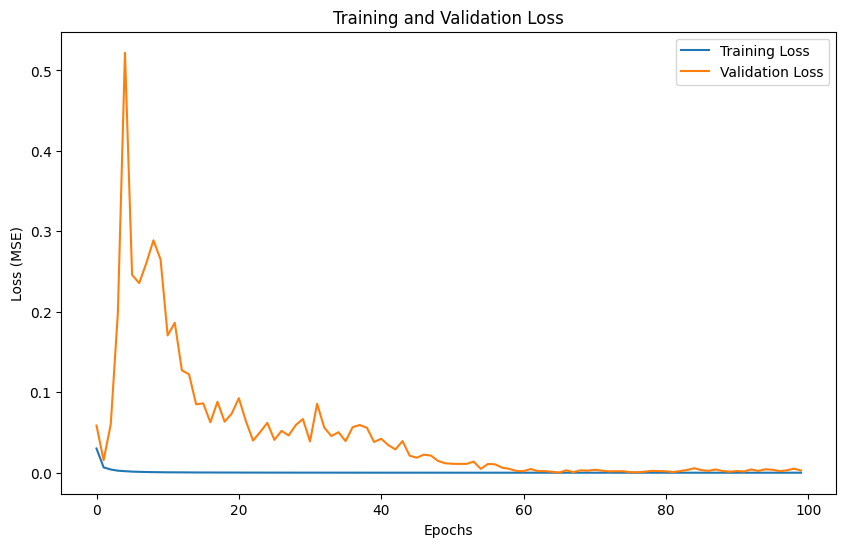

In [112]:
# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


70/70 [==============================] - 1s 8ms/step


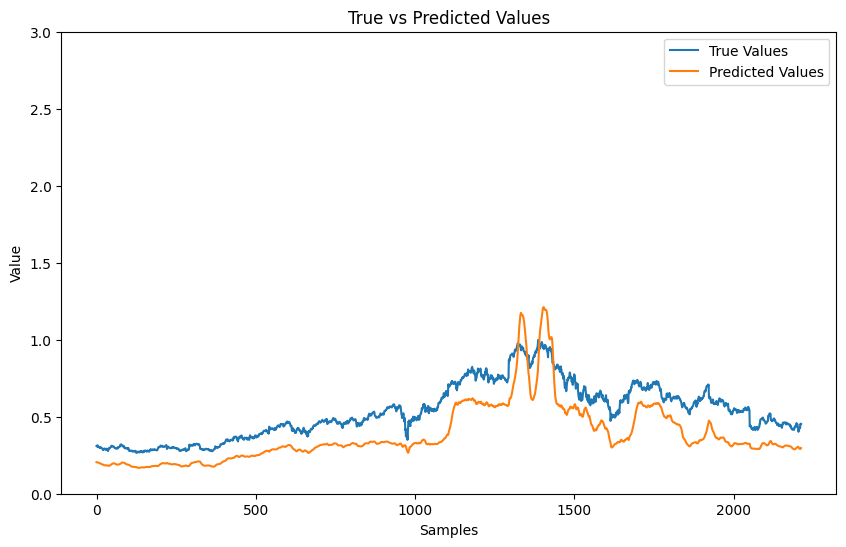

In [122]:
Y_pred = model.predict(X_test)

# Plot true vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_test, label='True Values')
plt.plot(Y_pred, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.ylim(0,3)
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()


In [127]:
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.028654
Root Mean Squared Error (RMSE): 0.169275
Mean Absolute Error (MAE): 0.160679
R² Score: 0.1152
